Model training completed in 43.8902 seconds
Number of iterations: 1000
MAE: 52614.34901449739
MSE: 5233384098.792266
RMSE: 72342.13225218252
R²: 0.6023443153510861

Final Model Performance Summary:
Initial cost: 56532442521.3654
Final cost: 5112169644.1901
Cost reduction: 51420272877.1754 (90.96%)
Converged after 1000 iterations
Average time per iteration: 0.043890 seconds


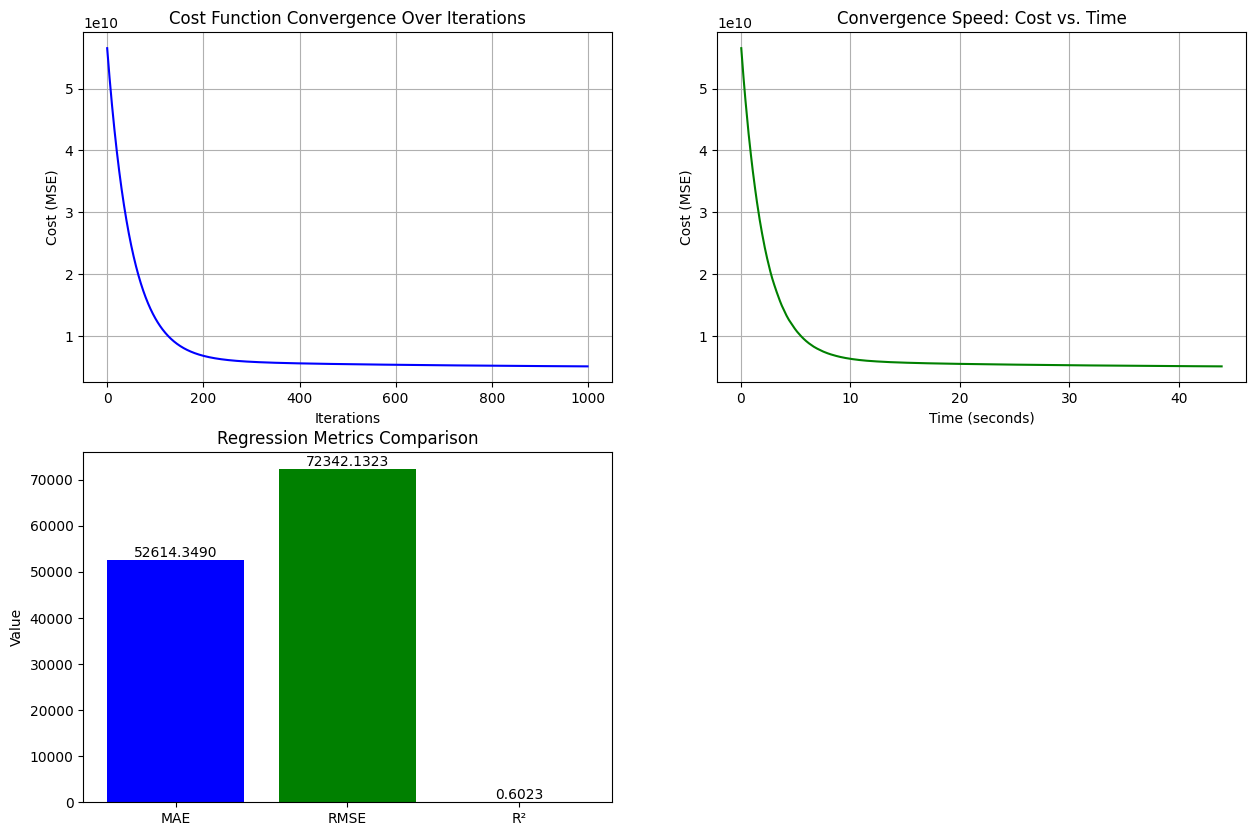

In [10]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv('../input/california-housing-prices/housing.csv')
X = data[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income']]
y = data.median_house_value
X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
features_mean = X_train.mean()
features_std = X_train.std()
X_train_std = (X_train - features_mean) / features_std
X_test_std = (X_test - features_mean) / features_std
X_train_std['bias'] = 1.0
X_test_std['bias'] = 1.0
X_train_records = X_train_std.to_dict('records')
X_test_records = X_test_std.to_dict('records')
y_train_list = y_train.tolist()
y_test_list = y_test.tolist()

def pure_python_gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    feature_names = list(X[0].keys())
    n_samples = len(X)
    weights = {feature: 0.0 for feature in feature_names}
    
    costs = []
    times = []
    start_time = time.time()
    
    for iteration in range(iterations):
        predictions = []
        for i in range(n_samples):
            sample = X[i]
            prediction = sum(sample[feature] * weights[feature] for feature in feature_names)
            predictions.append(prediction)
            
        gradients = {}
        for feature in feature_names:
            gradient_sum = sum((predictions[i] - y[i]) * X[i][feature] for i in range(n_samples))
            gradients[feature] = (1/n_samples) * gradient_sum
        
        for feature in feature_names:
            weights[feature] -= learning_rate * gradients[feature]
        
        cost = sum((predictions[i] - y[i]) ** 2 for i in range(n_samples)) / n_samples
        costs.append(cost)
        times.append(time.time() - start_time)
        
        if iteration > 0 and abs(costs[-1] - costs[-2]) < 1e-6:
            break
    total_time = time.time() - start_time
    return weights, costs, times, total_time
start_overall = time.time()
weights, costs, times, training_time = pure_python_gradient_descent(X_train_records, y_train_list, learning_rate=0.01)
end_overall = time.time()
print(f"Model training completed in {training_time:.4f} seconds")
print(f"Number of iterations: {len(costs)}")
predictions = []
for sample in X_test_records:
    prediction = sum(sample[feature] * weights[feature] for feature in weights.keys())
    predictions.append(prediction)
mae = sum(abs(pred - actual) for pred, actual in zip(predictions, y_test_list)) / len(y_test_list)
mse = sum((pred - actual) ** 2 for pred, actual in zip(predictions, y_test_list)) / len(y_test_list)
rmse = mse ** 0.5
y_mean = sum(y_test_list) / len(y_test_list)
ss_total = sum((actual - y_mean) ** 2 for actual in y_test_list)
ss_residual = sum((actual - pred) ** 2 for actual, pred in zip(y_test_list, predictions))
r2 = 1 - (ss_residual / ss_total)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(range(len(costs)), costs, 'b-')
plt.xlabel('Iterations')
plt.ylabel('Cost (MSE)')
plt.title('Cost Function Convergence Over Iterations')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(times, costs, 'g-')
plt.xlabel('Time (seconds)')
plt.ylabel('Cost (MSE)')
plt.title('Convergence Speed: Cost vs. Time')
plt.grid(True)

plt.subplot(2, 2, 3)
metrics = ['MAE', 'RMSE', 'R²']
values = [mae, rmse, r2]
colors = ['blue', 'green', 'orange']
bars = plt.bar(metrics, values, color=colors)
plt.ylabel('Value')
plt.title('Regression Metrics Comparison')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')
print(f"\nFinal Model Performance Summary:")
print(f"Initial cost: {costs[0]:.4f}")
print(f"Final cost: {costs[-1]:.4f}")
print(f"Cost reduction: {costs[0] - costs[-1]:.4f} ({(1 - costs[-1]/costs[0])*100:.2f}%)")
print(f"Converged after {len(costs)} iterations")
print(f"Average time per iteration: {training_time/len(costs):.6f} seconds")
